# Data Exploration

### Read in data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
df_logs = pd.read_excel(xls, sheet_name='question_behavior_log')
df_attempts = pd.read_csv('./attempts.tsv',sep = '\t')
df_questions = pd.read_csv('./question_details.tsv',sep = '\t')
df_metadata = pd.read_csv('./question_meta_data.csv')

### Take a glimpse to the data used

The recorded interaction ------ 118,308 records

In [3]:
df_logs.head()

,id,question_code,action,question_state,action_object_id,frontend_user_id,from_state,result_state,question_score,created_at
0,37660,M1702003,dragend,"{""q1"":[1,1]}",o1,5729,\0,\0,33,2018-03-28 08:57:59
1,37661,M1702003,dragend,"{""q1"":[3,3]}",o1,5729,\0,\0,100,2018-03-28 08:58:16
2,37764,M1702003,dragend,"{""q1"":[3,4]}",o1,15663,\0,\0,33,2018-03-28 12:25:04
3,37765,M1702003,dragend,"{""q1"":[3,3]}",o1,15663,\0,\0,100,2018-03-28 12:25:24
4,37807,M1702003,dragend,"{""q1"":[1,2]}",o1,11207,\0,\0,33,2018-03-28 13:51:55


In [4]:
df_logs.shape

(118308, 10)

The recorded score ------13,020 records, and after drop duplicates, there still have 10,478 records

In [5]:
df_attempts.head()

,question_code,question_state,frontend_user_id,question_score,created_at
0,ICM0901127,"{""answer"":[""7"",""6""]}",4792,100,28/12/2017 10:29:02
1,ICM0901127,"{""answer"":[""7"",""6""]}",4862,100,2/10/2017 13:05:01
2,ICM0901127,"{""answer"":[""6"",""3""]}",4861,100,2/10/2017 14:02:29
3,ICM0901127,"{""answer"":[""5"",""7""]}",4857,0,5/10/2017 12:18:07
4,ICM0901127,"{""answer"":[""6"",""7""]}",4267,100,6/10/2017 11:25:07


In [6]:
df_attempts.shape

(13020, 5)

The types and ID of questions

In [7]:
df_questions = df_questions.rename(columns={'group_concat(distinct categories.name)': 'group'})
df_questions.head()

,code,name,group
0,ICM0901127,Dotsym,Spatial
1,ICM0901049,Squarepair,Spatial
2,ICM1300129,Hexahide,Geometry
3,ICM1300157,Co-ordinates,Geometry
4,MI133051,Transform,Geometry


In [8]:
df_questions.shape

(59, 3)

The difficulty and grade of questions

In [9]:
df_metadata.head()

,question_id,name,grade,difficulty,question_objectives
0,1,Zig Zag,6,2,To explore a situation to find and prove gener...
1,2,Squarepull,5,2,"To design an object, mechanism or structure, o..."
2,3,Shader,5,2,To extract some specified further information ...
3,6,Hexagology,1,1,To extract some specified further information ...
4,7,One two three,3,3,To extract some specified further information ...


In [10]:
df_metadata.shape

(1681, 5)

### At Question Level to explore the data

Because the questions' information doesn't store in the same files, we need to combine these information first

In [11]:
df_ques = pd.merge(df_attempts,df_questions,right_on = 'code',left_on = 'question_code')\
    .drop(['question_state','code','created_at'],axis = 1)
df_ques = pd.merge(df_ques, df_metadata).drop_duplicates()\
            .drop(['question_objectives','question_id'],axis=1)
df_ques.head()

,question_code,frontend_user_id,question_score,name,group,grade,difficulty
0,ICM0901127,4792,100,Dotsym,Spatial,4,2
1,ICM0901127,4862,100,Dotsym,Spatial,4,2
2,ICM0901127,4861,100,Dotsym,Spatial,4,2
3,ICM0901127,4857,0,Dotsym,Spatial,4,2
4,ICM0901127,4267,100,Dotsym,Spatial,4,2


Find the average score of each question

In [12]:
df_difftoscore = df_ques.groupby('question_code')\
        .agg({'frontend_user_id':'count','question_score':'mean','difficulty': 'mean'})\
        .sort_values('difficulty')\
        .rename(columns = {'frontend_user_id': 'user_number'})
df_difftoscore.head()

,difficulty,user_number,question_score
question_code,,,
N1310001,1.0,392,76.466837
N1310002,1.0,326,79.555215
M1703004,1.0,198,58.833333
M1702004,1.0,487,85.174538
S1213003,1.0,314,83.439490


Draw the pic to show the relation between difficulty and score

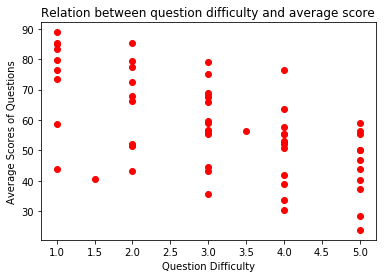

In [13]:
x = df_difftoscore['difficulty']
y = df_difftoscore['question_score']
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.set_title('Relation between question difficulty and average score')

plt.xlabel('Question Difficulty')

plt.ylabel('Average Scores of Questions')

ax1.scatter(x,y,c = 'r',marker = 'o')

plt.legend('x1').remove()

plt.show()

Maybe can set a score range for questions in different difficulty level,which could help to find the questions who is set wrong difficulty label

### At Time Level to explore the data

Because the recorded timestamp is based on the Greenwich zone, we need to analyze the data on time level after transform the timestamp into Beijing zone.
And I separate a day into four parts:
0 stands for 0am - 5.59am
1 stands for 6am - 11.59am
2 stands for 12am - 5.59pm
3 stands for 6pm - 11.59pm

In [14]:
def getchhour(arr):
    hour = int(arr.split(':')[0].split(' ')[1])
    if 16<hour<22 or hour ==16:
        return 0;
    elif 22<hour or hour<4 or hour ==22:
        return 1;
    elif 4<hour<10 or hour == 4:
        return 2;
    else: return 3;

In [15]:
df_logswhen = df_logs.drop(['id','action','question_state','action_object_id','from_state','result_state'],axis=1)\
        .groupby(['frontend_user_id','question_code'])\
        .agg({'created_at': min,'question_score': max})
df_logswhen['created_at'] = df_logswhen['created_at'].map(lambda x: getchhour(str(x)))
df_logswhen.head()

created_at question_score
frontend_user_id question_code                           
2                A1103003                2             50
                 D1401003                2             66
                 S1501001                2             80
4094             ICM0901049              1             \0
                 M1702004                2            100

Count the number of students and questions in each time parts

In [16]:
def countnum(arr):
    return len(arr)
df_logswhen.reset_index()\
            .groupby(['created_at','frontend_user_id'])\
            .agg({'question_code': countnum})\
            .reset_index()\
            .groupby('created_at')\
            .agg({'frontend_user_id': countnum,'question_code': sum})

,frontend_user_id,question_code
created_at,,
0,23,74
1,475,1549
2,872,3367
3,746,3030


Use a pie chart to find the ratio of question numbers in each part

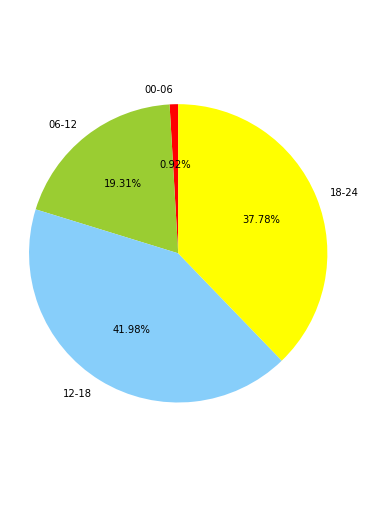

In [17]:
plt.figure(figsize=(6,9))
labels = [u'00-06',u'06-12',u'12-18',u'18-24'] 
sizes = [74,1549,3367,3030]
colors = ['red','yellowgreen','lightskyblue','yellow'] 
explode = (0,0,0,0) 
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      autopct = '%3.2f%%', 
                      shadow = False, 
                      startangle =90, 
                      pctdistance = 0.6) 

plt.axis('equal')
plt.show()

#### Combine Time and Score 

Delete the useless score records

In [18]:
def f(x):
    if "\\" in str(x):
        return -1
    return x
df_logswhen['question_score'] = df_logswhen['question_score'].map(f)
df_logswhenII = df_logswhen[df_logswhen['question_score'] != -1]

In [19]:
def scorechange(arr):
    if 0<=arr<=25: return 0;
    elif 25<arr<=50: return 1;
    elif 50<arr<=75: return 2;
    else: return 3;
df_scorewhen = df_logswhenII#.drop('index',axis = 1)
df_scorewhen['question_score'] = df_scorewhen['question_score'].map(scorechange)
df_scorewhen.head()

/Applications/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


created_at  question_score
frontend_user_id question_code                            
2                A1103003                2               1
                 D1401003                2               2
                 S1501001                2               3
4094             M1702004                2               3
                 M1703004                2               3

Prepare data for drawing

In [20]:
df_scorewhengra = df_scorewhen.reset_index().groupby(['created_at','question_score']).count().reset_index()
df_scorefir = df_scorewhengra[df_scorewhengra['question_score']==0].reset_index()
df_scoresec = df_scorewhengra[df_scorewhengra['question_score']==1].reset_index()
df_scorethi = df_scorewhengra[df_scorewhengra['question_score']==2].reset_index()
df_scorefor = df_scorewhengra[df_scorewhengra['question_score']==3].reset_index()
df_scorewhengra.head()

,created_at,question_score,frontend_user_id,question_code
0,0,0,3,3
1,0,1,2,2
2,0,2,1,1
3,0,3,18,18
4,1,0,143,143


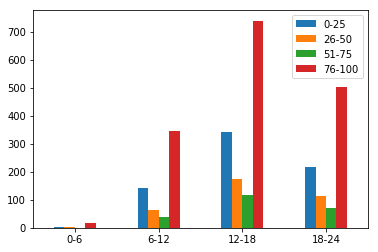

In [21]:
def changearr(df,attrinum):
    a = []
    j = 0
    for i in range(len(df)):
        if (df['created_at'][i] - j) == 0:
            a.append(df['question_code'][i])
            j = j+1
            if j==len(df):
                if j != attrinum:
                    for h in range(attrinum-j):
                        a.append(0)
        elif (df['created_at'][i] - j)>0:
            for k in range(df['created_at'][i] - j):
                a.append(0)
            j = df['created_at'][i]
        else:
            a.append(0)
            j = j+1
            if j == attrinum: break
    return a
df = pd.DataFrame({'0-25': changearr(df_scorefir,4),
                   '26-50':changearr(df_scoresec,4),
                   '51-75':changearr(df_scorethi,4),
                   '76-100':changearr(df_scorefor,4)}, index=['0-6','6-12','12-18','18-24'])
ax = df.plot.bar(rot=0)
plt.show()

It seems that the score isn't related tightly with the time when students learn in a day. In order to understand more details, let's draw a 24h line chart. 

In [22]:
def geteveryhour(arr):
    hour = int(arr.split(':')[0].split(' ')[1])
    if hour < 16: hour = hour + 8
    else: hour = hour-16
    if hour<10:
        return '0' + str(hour) +':00';
    else:
        return str(hour) + ':00'

def getmean(arr):
    total = 0
    for i in arr:
        total = total + i
    return total/len(arr)
df_everywhen = df_attempts.drop_duplicates()\
            .groupby(['frontend_user_id','question_code'])\
            .agg({'created_at': min,'question_score': max}).reset_index()
df_everywhen['Time_in_a_day'] = df_everywhen['created_at'].map(lambda x: geteveryhour(x))
df_everywhen.head()

,frontend_user_id,question_code,created_at,question_score,Time_in_a_day
0,4094,ICM0901049,17/4/2018 2:32:30,100,10:00
1,4094,ICM0901127,28/11/2017 14:09:19,0,22:00
2,4094,M1702003,18/12/2017 3:49:49,100,11:00
3,4094,M1702004,5/4/2018 6:50:32,100,14:00
4,4094,M1703004,5/4/2018 7:08:38,100,15:00


In [23]:
df_everyhourplot = df_everywhen.groupby('Time_in_a_day').agg({'frontend_user_id': countnum, 'question_score': getmean})\
                                .rename(columns = {'frontend_user_id': 'user_number','question_score':'average_score'})

Draw the line chart

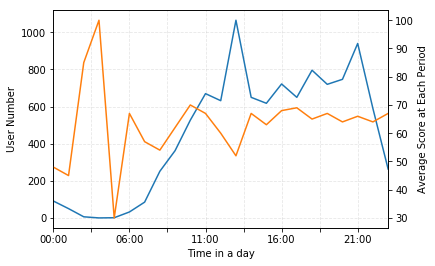

In [24]:
ax = df_everyhourplot.plot(
    secondary_y=['average_score'],
    x_compat=True,
    grid=True)

ax.set_title("")
ax.set_ylabel('User Number')
ax.set_xlabel('Time in a day')
ax.grid(linestyle="--", alpha=0.3)

ax.right_ax.set_ylabel('Average Score at Each Period')
ax.legend_.remove()
plt.show()

From the line chart, it shows that students have different learning performance at different time in a day. <br>

Attention: if we indeed want to know if hours could give some evidences about student learning habit, we need to collect more data of a student. The interaction records of each person in the dataset are always created by the person in one day.

### At Weekday Level to explore the data

In [25]:
def chdate(arr):
    if int(str(arr).split(' ')[1].split(':')[0]) > 15:
        arr = pd.to_datetime(pd.to_datetime(str(arr).split(' ')[0],errors='coerce') + datetime.timedelta(days = 1),errors='coerce')
    else:
        arr = pd.to_datetime(str(arr).split(' ')[0],errors='coerce')
    return arr 
df_weekday=df_attempts.drop_duplicates()\
            .groupby(['frontend_user_id','question_code'])\
            .agg({'created_at': min,'question_score': max}).reset_index()
df_weekday['weekday'] = df_weekday['created_at'].map(lambda x : chdate(x))
df_weekday['weekday'] = pd.to_datetime(df_weekday['weekday'], errors='coerce')
df_weekday['weekday'] = df_weekday['weekday'].dt.weekday.rename(columns={'created_at': 'weekday'})
df_weekday.head()

,frontend_user_id,question_code,created_at,question_score,weekday
0,4094,ICM0901049,17/4/2018 2:32:30,100,1
1,4094,ICM0901127,28/11/2017 14:09:19,0,1
2,4094,M1702003,18/12/2017 3:49:49,100,0
3,4094,M1702004,5/4/2018 6:50:32,100,4
4,4094,M1703004,5/4/2018 7:08:38,100,4


In [26]:
df_weekhourplot = df_weekday
df_weekhourplot['created_at'] = df_weekhourplot['created_at'].map(getchhour)
df_weekhourplot=df_weekhourplot.groupby(['weekday','created_at'])\
                .agg({'question_score':getmean,'frontend_user_id': countnum})\
                .reset_index()
df_weekhourplot.head()

,weekday,created_at,frontend_user_id,question_score
0,0,0,13,82
1,0,1,167,63
2,0,2,454,56
3,0,3,438,61
4,1,0,9,81


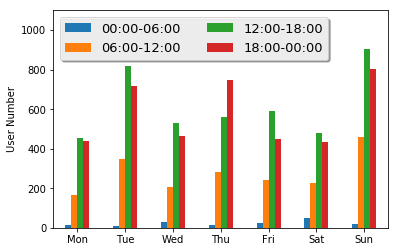

In [27]:
def getarr(arr):
    a = []
    for i in arr:
        a.append(i)
    return a

df = pd.DataFrame({'00:00-06:00': getarr(df_weekhourplot[df_weekhourplot['created_at']==0].reset_index().drop('index',axis=1)['frontend_user_id']),
                   '06:00-12:00':getarr(df_weekhourplot[df_weekhourplot['created_at']==1].reset_index().drop('index',axis=1)['frontend_user_id']),
                   '12:00-18:00':getarr(df_weekhourplot[df_weekhourplot['created_at']==2].reset_index().drop('index',axis=1)['frontend_user_id']),
                   '18:00-00:00':getarr(df_weekhourplot[df_weekhourplot['created_at']==3].reset_index().drop('index',axis=1)['frontend_user_id'])},
                  index=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax = df.plot.bar(rot=0)
plt.ylabel('User Number')
plt.legend(loc='upper left', bbox_to_anchor=(0,0.999),ncol=2,fancybox=True,shadow=True,fontsize=13)
plt.ylim((0,1100))
plt.show()